In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats as st
import time 

from lfimodels.balancednetwork.BalancedNetworkSimulator import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats
from lfimodels.balancednetwork.BalancedNetworkGenerator import BalancedNetworkGenerator

%matplotlib inline

### Define the objects we need for the simulation: 

model, prior, summarystats, a generator to combine it all

In [2]:
n_params = 4

m = BalancedNetwork(dim=n_params, first_port=8010, 
                    verbose=False, n_servers=4, duration=3.)
p = dd.Uniform(lower=[0.01] * n_params, upper=[0.1] * n_params)
s = BalancedNetworkStats()
g = BalancedNetworkGenerator(model=m, prior=p, summary=s)

### Make an observation by running the parameters from the paper

In [5]:
# here we set the true params 
true_params = [[0.024, 0.045, 0.014, 0.057]]  # params from the paper 
# run forward model 
data = m.gen(true_params)
# get summary stats
stats_obs = s.calc(data[0])

starting 1 / 1. total time remaining: ca. 0.5min 
Done


In [6]:
print(true_params, stats_obs)

[[0.024, 0.045, 0.014, 0.057]] [[ 1.14786328  4.57677083  1.66666667  5.52149065  0.00585257]]


In [7]:
# set up inference
res = infer.Basic(g, n_components=3, pilot_samples=0)

starting 1 / 1. total time remaining: ca. 0.5min 
Done


In [8]:
ntrain = 20
# run with N samples
out, trn_data = res.run(ntrain, epochs=1000, minibatch=10)

starting 1 / 20. total time remaining: ca. 2.5min 
starting 7 / 20. total time remaining: ca. 1.5min 
starting 3 / 20. total time remaining: ca. 2.0min 
starting 5 / 20. total time remaining: ca. 2.0min 
starting 2 / 20. total time remaining: ca. 2.0min 
starting 4 / 20. total time remaining: ca. 2.0min 
starting 8 / 20. total time remaining: ca. 1.5min 
starting 9 / 20. total time remaining: ca. 1.5min 
starting 11 / 20. total time remaining: ca. 1.0min 
starting 12 / 20. total time remaining: ca. 1.0min 
starting 13 / 20. total time remaining: ca. 1.0min 
starting 6 / 20. total time remaining: ca. 1.5min 
starting 10 / 20. total time remaining: ca. 1.0min 
starting 15 / 20. total time remaining: ca. 0.5min 
starting 14 / 20. total time remaining: ca. 0.5min 
starting 17 / 20. total time remaining: ca. 0.5min 
starting 18 / 20. total time remaining: ca. 0.0min 
starting 19 / 20. total time remaining: ca. 0.0min 
starting 16 / 20. total time remaining: ca. 0.5min 
starting 20 / 20. tot

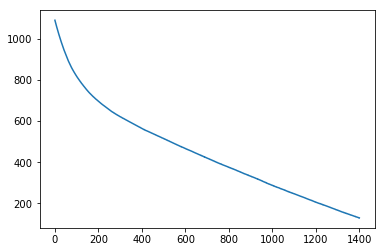

In [9]:
plt.plot(out['loss']);

In [10]:
m.stop_server()

## Test the result: plot the result posterior

In [22]:
# evaluate the posterior at the observed data 
posterior = res.predict(stats_obs)

In [23]:
# set up a dict for saving the results 
save_data = True
path_to_save_folder = 'data/'  # has to exist on your local path

if save_data and os.path.exists(path_to_save_folder): 
    nrounds=1
    result_dict = dict(true_params=true_params, stats_obs=stats_obs, nrouns=nrounds, ntrain=ntrain,
                       posterior=posterior, out=out, trn_data=trn_data)
    
    filename = os.path.join(path_to_save_folder, 
                           '{}_basic_ntrain{}'.format(time.time(), ntrain).replace('.', '') + '.p')
    with open(filename, 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(filename)

data/15034110564604049_basic_ntrain20.p


In [24]:
# extract the posterior 
n_components = len(posterior.a)
means = [posterior.xs[c].m for c in range(n_components)]
Ss = [posterior.xs[c].S for c in range(n_components)]

In [26]:
def get_delfi_grid_pdf(theta, delfi_obj): 
    """
    Get pdf of a whole grid of values 
    """
    x, y = np.meshgrid(theta, theta)
    z = np.zeros_like(x)
    for i in range(z.shape[0]): 
        # arrange the samples in rows 
        v = np.array([x[i, :], y[i, :]]).T
        # evaluate the pdf for rows of z
        z[i, :] = delfi_obj.eval(x=v)
    return x, y, z

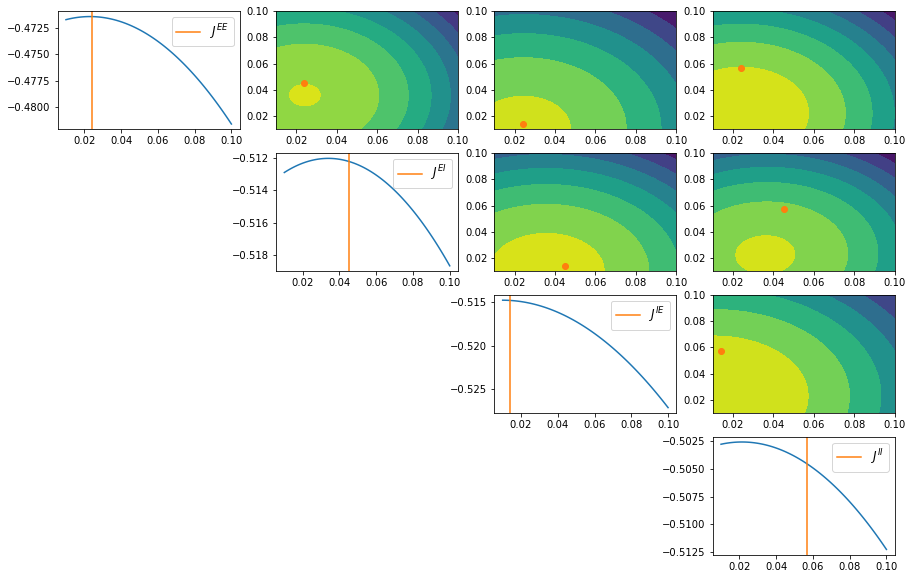

In [27]:
dim_params = n_params 

plt.figure(figsize=(15, 10))
theta = np.linspace(0.01, 0.1, 100)
weight_labels = ['$J^{EE}$', '$J^{EI}$', '$J^{IE}$', '$J^{II}$']
plot_idx = 1
for i in range(dim_params): 
    for j in range(dim_params): 
        if i==j: 
            
            # define a 1D MoG
            sub_means = [[means[c][i]] for c in range(n_components)]
            sub_cov = [[[Ss[c][i, j]]] for c in range(n_components)]
            pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
            post_pdf = pdf.eval(theta[:, np.newaxis])
            
            plt.subplot(dim_params, dim_params, plot_idx)            
            plt.plot(theta, post_pdf)
            plt.axvline(x=true_params[0][i], color='C1', label=weight_labels[i])
            plt.legend(prop=dict(size=12))
            
        elif i < j:            
            # define a 2D MoG
            sub_means = [[posterior.xs[c].m[i], posterior.xs[c].m[j]] for c in range(n_components)]
            sub_cov = [[[posterior.xs[c].S[i, i], posterior.xs[c].S[i, j]], 
                       [posterior.xs[c].S[j, i], posterior.xs[c].S[j, j]]] for c in range(n_components)]
            pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)            
            x, y, z = get_delfi_grid_pdf(theta, delfi_obj=pdf)
        
            plt.subplot(dim_params, dim_params, plot_idx)
            plt.contourf(x, y, z)
            plt.plot([true_params[0][i]], [true_params[0][j]], 'o', color='C1')
        plot_idx += 1 